# GeometricWidthDiscretiser + MeanEncoder

This is very useful for linear models, because by using discretisation + a monotonic encoding, we create monotonic variables with the target, from those that before were not originally. And this tends to help improve the performance of the linear model. 

## GeometricWidthDiscretiser

The GeometricWidthDiscretiser() divides continuous numerical variables into
intervals of increasing width with equal increments. Note that the
proportion of observations per interval may vary.

The size of the interval will follow geometric progression.

## MeanEncoder

This encoder replaces the labels by the target mean.

<b>Note:</b> Check out the MeanEncoder notebook to learn more about this transformer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from feature_engine.discretisation import GeometricWidthDiscretiser
from feature_engine.encoding import MeanEncoder

plt.rcParams["figure.figsize"] = [15,5]

In [2]:
# Load titanic dataset from file

def load_titanic(filepath='titanic.csv'):
    # data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = pd.read_csv(filepath)
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float').fillna(data.age.median())
    data['fare'] = data['fare'].astype('float').fillna(data.fare.median())
    data['embarked'].fillna('C', inplace=True)
    # data.drop(labels=['boat', 'body', 'home.dest', 'name', 'ticket'], axis=1, inplace=True)
    return data

In [3]:
# data = load_titanic("../data/titanic.csv")
data = load_titanic("../data/titanic-2/Titanic-Dataset.csv")
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,n,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,n,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,n,S


In [4]:
# let's separate into training and testing set
X = data.drop(['survived'], axis=1)
y = data.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train :" ,X_train.shape)
print("X_test :" ,X_test.shape)

X_train : (623, 11)
X_test : (268, 11)


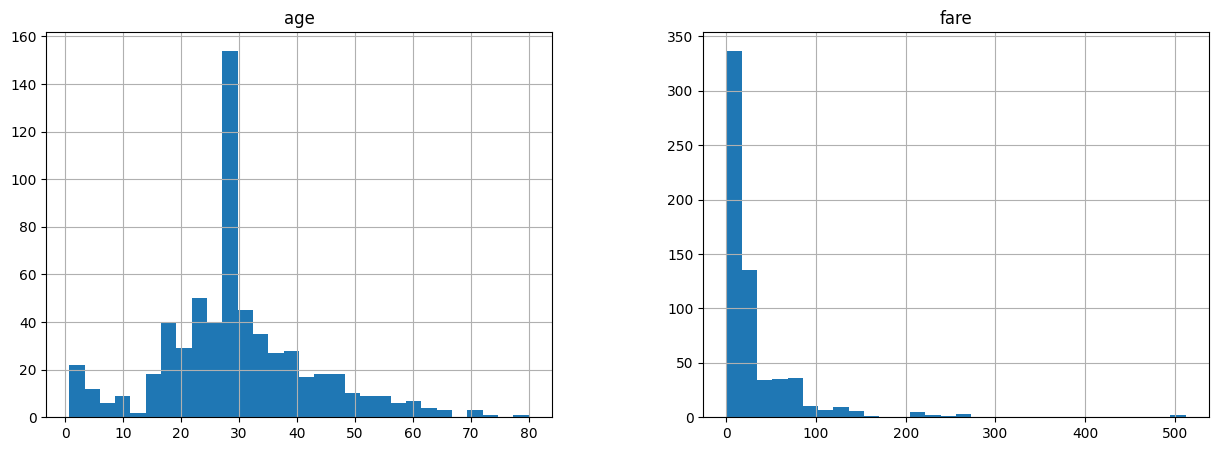

In [5]:
# we will use two continuous variables for the transformations
X_train[["age", 'fare']].hist(bins=30)
plt.show()

In [6]:
# set up the discretiser

efd = GeometricWidthDiscretiser(
    bins=5,
    variables=['age', 'fare'],
    # important: return values as categorical
    return_object=True)

# set up the encoder
woe = MeanEncoder(variables=['age', 'fare'])

# pipeline
transformer = Pipeline(
    steps=[
        ('GeometricWidthDiscretiser', efd),
        ('MeanEncoder', woe),
    ]
)

transformer.fit(X_train, y_train)

Pipeline(steps=[('GeometricWidthDiscretiser',
                 GeometricWidthDiscretiser(bins=5, return_object=True,
                                           variables=['age', 'fare'])),
                ('MeanEncoder', MeanEncoder(variables=['age', 'fare']))])

In [7]:
transformer.named_steps['GeometricWidthDiscretiser'].binner_dict_

{'age': [-inf,
  3.0682115533553374,
  6.42141865464702,
  14.463118665757897,
  33.748816541021746,
  inf],
 'fare': [-inf,
  3.482649927509053,
  12.128850517578812,
  42.24054037581399,
  147.1090148777718,
  inf]}

In [8]:
transformer.named_steps['MeanEncoder'].encoder_dict_

{'age': {0: 0.5909090909090909,
  1: 0.7142857142857143,
  2: 0.47058823529411764,
  3: 0.3619791666666667,
  4: 0.3870967741935484},
 'fare': {0: 0.0,
  1: 0.23140495867768596,
  2: 0.43902439024390244,
  3: 0.6146788990825688,
  4: 0.5789473684210527}}

In [9]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
495,496,3,"Yousseff, Mr. Gerious",male,0.361979,0,0,2627,0.439024,n,C
648,649,3,"Willey, Mr. Edward",male,0.361979,0,0,S.O./P.P. 751,0.231405,n,S
278,279,3,"Rice, Master. Eric",male,0.470588,4,1,382652,0.439024,n,Q
31,32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,0.361979,1,0,PC 17569,0.614679,B,C
255,256,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,0.361979,0,2,2650,0.439024,n,C


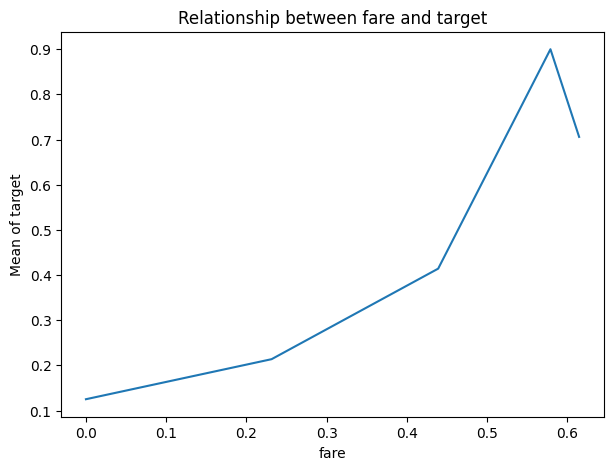

In [10]:
# let's explore the monotonic relationship
plt.figure(figsize=(7,5))
pd.concat([test_t,y_test], axis=1).groupby("fare")["survived"].mean().plot()
plt.title("Relationship between fare and target")
plt.xlabel("fare")
plt.ylabel("Mean of target")
plt.show()